# August Temperature Blitz Analysis

In [171]:
###import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import optimize
from sklearn.linear_model import LinearRegression
import seaborn as sns
from datetime import timedelta
from datetime import datetime
import datetime as dt
import warnings

### Data for Analysis
Data created using the August Temperature Blitz Sanitation file is shown here

In [172]:
#load CSVs created in sanitization notebook
AugBlitz = pd.read_csv('AugBlitzComplete.csv').iloc[:, 1:]
AugBlitz.DateTime = pd.to_datetime(AugBlitz.DateTime)
#create binary columns to perform regressions on Sun/Shade and tree presence
SunShadeBinary = []
TreeBinary = []
for index, row in AugBlitz.iterrows():
    if row['Sun/Shade'] == 'Sun': SunShadeBinary.append(1)
    else: SunShadeBinary.append(0)
    if row['Trees?'] == 'Y': TreeBinary.append(1)
    else: TreeBinary.append(0)
AugBlitz['Sun/Shade Binary'] =  SunShadeBinary
AugBlitz['Tree Binary'] = TreeBinary

#convert Timestamp to minutes elapsed in day to use time in regression calculations
minute_of_day = []
for minute in AugBlitz['DateTime']:
    minutes = minute - pd.to_datetime('2022-08-11 0:00:00')
    diff_in_minutes = minutes.total_seconds() / 60
    minute_of_day.append(diff_in_minutes)
AugBlitz['Minute of Day'] = minute_of_day
AugBlitz['Hour of Day'] = AugBlitz.DateTime.dt.hour

AugBlitz['StartTime'] = pd.to_datetime(AugBlitz['StartTime']).apply(lambda dt: dt.replace(year=2022, month=8, day=11))
AugBlitz['EndTime'] = pd.to_datetime(AugBlitz['EndTime']).apply(lambda dt: dt.replace(year=2022, month=8, day=11))
AugBlitz

,DateTime,StartTime,EndTime,SurfaceLogger,StartSurfaceTemp,EndSurfaceTemp,PoleLogger,PoleTemp,Utility Pole #,Latitude,Longitude,Sun/Shade,Trees?,SummedBA,DistanceDecay,Sun/Shade Binary,Tree Binary,Minute of Day,Hour of Day
0,2022-08-11 08:46:00,2022-08-11 08:40:00,2022-08-11 08:46:00,21302958,24.24,20.16,21302967,17.930,TP6262,47.213277,-122.483526,Shade,Y,2.424760,0.041437,0,1,526.0,8
1,2022-08-11 08:56:00,2022-08-11 08:51:00,2022-08-11 08:56:00,21302954,22.73,28.48,21302950,18.530,TP6340,47.216117,-122.473789,Sun,N,0.000000,0.000000,1,0,536.0,8
2,2022-08-11 08:56:00,2022-08-11 08:50:00,2022-08-11 08:56:00,21302958,20.93,19.30,21223106,18.711,TPU927,47.214566,-122.483749,Shade,N,0.000000,0.000000,0,0,536.0,8
3,2022-08-11 08:57:00,2022-08-11 08:52:00,2022-08-11 08:57:00,21302978,28.53,32.64,21223121,19.282,TP23269,47.216736,-122.480436,Sun,N,0.018928,0.000386,1,0,537.0,8
4,2022-08-11 09:00:00,2022-08-11 08:55:00,2022-08-11 09:00:00,21302973,24.66,30.07,21223123,19.187,TP20171,47.209033,-122.475016,Sun,N,0.000000,0.000000,1,0,540.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2022-08-11 15:23:00,2022-08-11 15:19:00,2022-08-11 15:23:00,21302978,42.47,46.29,21302971,26.340,TP25239/A1353202,47.226325,-122.473356,Sun,N,0.000000,0.000000,1,0,923.0,15
107,2022-08-11 15:25:00,2022-08-11 15:20:00,2022-08-11 15:25:00,21302949,0.00,0.00,21223120,25.805,TP24409,47.213278,-122.473825,Sun,Y,0.004418,0.000092,1,1,925.0,15
108,2022-08-11 15:25:00,2022-08-11 15:20:00,2022-08-11 15:25:00,21302954,30.28,28.65,21302963,25.350,TP6325,NaN,NaN,Sun,NaN,0.000000,0.000000,1,0,925.0,15
109,2022-08-11 15:29:00,2022-08-11 15:24:00,2022-08-11 15:29:00,21302965,42.34,44.44,21223102,25.319,TP13987,47.220944,-122.484222,Sun,Y,0.141372,0.006381,1,1,929.0,15


### Tacoma Temperature Logger Locations
This map shows the location of each referenced temperature logger. Marker shape is used here to identify whether the logger has tree coverage or not.

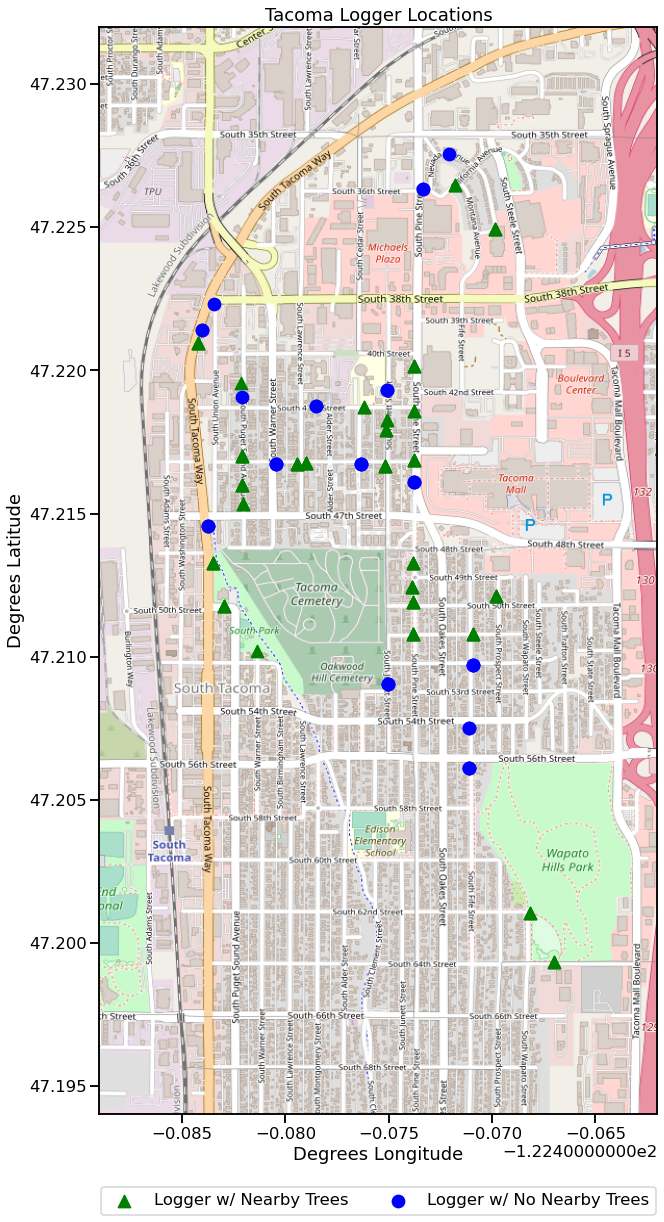

In [173]:
AugBlitzTrees = AugBlitz[AugBlitz['Trees?'] == 'Y']
AugBlitzNoTrees = AugBlitz[AugBlitz['Trees?'] == 'N']
###plot logger location
Dimensions = (-122.4890, -122.4620, 47.1940, 47.2320)
sns.set_context('talk')
Tacoma = plt.imread('Tacoma.png')
fig, (ax1) = plt.subplots(1, figsize = (10,20))
ax1.imshow(Tacoma, extent = Dimensions, aspect ='auto')
sns.set_context()
ax1.scatter(AugBlitzTrees.Longitude, AugBlitzTrees.Latitude, c='g', s=150, label='Logger w/ Nearby Trees', marker = '^')
ax1.scatter(AugBlitzNoTrees.Longitude, AugBlitzNoTrees.Latitude, c='b', s=150, label='Logger w/ No Nearby Trees')

#remove grid, add title, and place legend outside box to make legible
ax1.grid(False)
ax1.set_title('Tacoma Logger Locations')
ax1.set_xlim(Dimensions[0],Dimensions[1])
ax1.set_ylim(Dimensions[2],Dimensions[3])
ax1.set_ylabel('Degrees Latitude')
ax1.set_xlabel('Degrees Longitude')
ax1.legend(bbox_to_anchor=(.5, -0.1), loc='lower center', ncol=2)

### Individual Data Points Displayed
This scatter plot shows the individual data points recorded throughout the course of the Blitz. It is split up by whether the data point was in sun/shade, near trees/no trees, and if it was a pole logger/surface logger. This chart also neatly displays the three "shifts" of data collection (8a-10a, 11a-1p, 2p-4p) that occurred during the Blitz. <br> <br>
The presence of trees denoted here was decided by individual data collectors and presents bias in the data. Given sparse tree coverage (represented by a small summed basal area), it is difficult to describe in binary terms if there are trees or not. As shown in the correlation heatmap lower down, the summed basal area doesn't actually correlate that well to the binary yes/no of tree coverage answered by collectors.  <br> <br>
The bottom of the graph notes several outliers. The surface loggers with with 0C values were missing data. The red outlier on the bottom right hints at a possible malfunction in the readings from that logger.

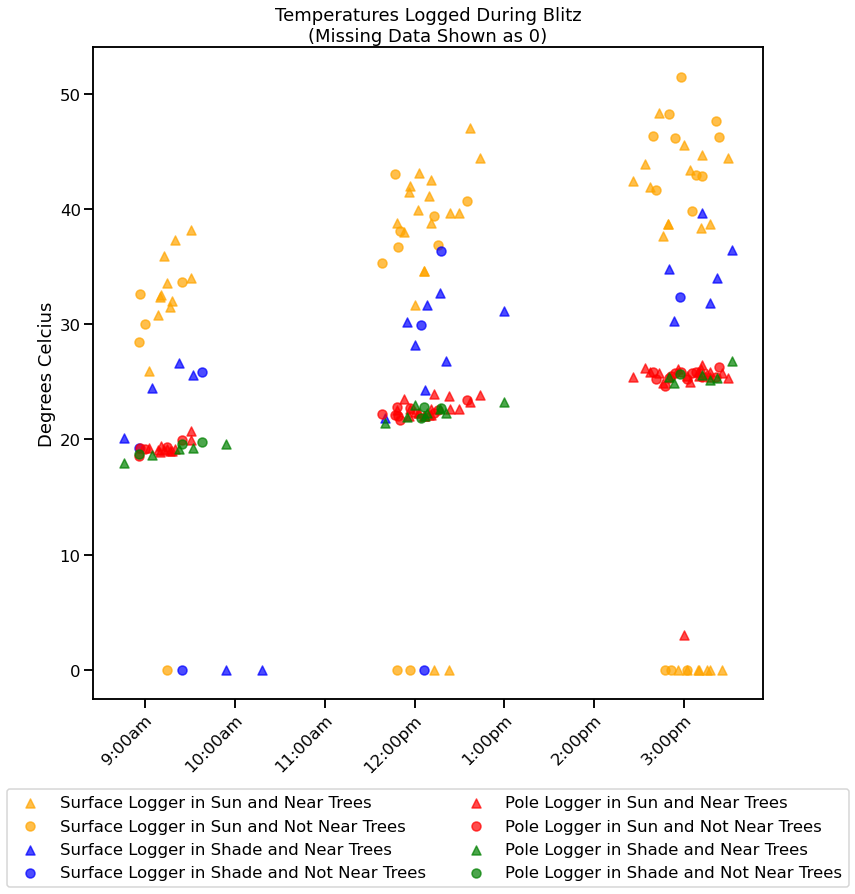

In [174]:
#unable to find data for surface loggers '21302949' and '21302945' - assigned to 0

#create DFs for each possibility of trees or sun
sns.set_context('talk')
AugBlitzSunAndTrees = AugBlitz[(AugBlitz['Sun/Shade'] == 'Sun') & (AugBlitz['Trees?'] == 'Y')]
AugBlitzSunNoTrees = AugBlitz[(AugBlitz['Sun/Shade'] == 'Sun') & (AugBlitz['Trees?'] == 'N')]
AugBlitzNoSunAndTrees = AugBlitz[(AugBlitz['Sun/Shade'] == 'Shade') & (AugBlitz['Trees?'] == 'Y')]
AugBlitzNoSunNoTrees = AugBlitz[(AugBlitz['Sun/Shade'] == 'Shade') & (AugBlitz['Trees?'] == 'N')]

#plot all values of surface loggers and pole loggers using color and marker type to differenciate.
fig, (ax1) = plt.subplots(sharex=True, sharey=True, figsize = (12,12))
ax1.scatter(AugBlitzSunAndTrees.DateTime, AugBlitzSunAndTrees.EndSurfaceTemp, alpha = .7, c = 'orange', label = 'Surface Logger in Sun and Near Trees', marker = '^')  
ax1.scatter(AugBlitzSunNoTrees.DateTime, AugBlitzSunNoTrees.EndSurfaceTemp, alpha = .7, c = 'orange', label = 'Surface Logger in Sun and Not Near Trees')
ax1.scatter(AugBlitzNoSunAndTrees.DateTime, AugBlitzNoSunAndTrees.EndSurfaceTemp, alpha = .7, c = 'blue', label = 'Surface Logger in Shade and Near Trees', marker = '^')
ax1.scatter(AugBlitzNoSunNoTrees.DateTime, AugBlitzNoSunNoTrees.EndSurfaceTemp, alpha = .7, c = 'blue', label = 'Surface Logger in Shade and Not Near Trees')
ax1.scatter(AugBlitzSunAndTrees.DateTime, AugBlitzSunAndTrees.PoleTemp, alpha = .7, c = 'red', label = 'Pole Logger in Sun and Near Trees', marker = '^')
ax1.scatter(AugBlitzSunNoTrees.DateTime, AugBlitzSunNoTrees.PoleTemp, alpha = .7, c = 'red', label = 'Pole Logger in Sun and Not Near Trees')
ax1.scatter(AugBlitzNoSunAndTrees.DateTime, AugBlitzNoSunAndTrees.PoleTemp, alpha = .7, c = 'green', label = 'Pole Logger in Shade and Near Trees', marker = '^')
ax1.scatter(AugBlitzNoSunNoTrees.DateTime, AugBlitzNoSunNoTrees.PoleTemp, alpha = .7, c = 'green', label = 'Pole Logger in Shade and Not Near Trees')

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
ax1.legend(bbox_to_anchor=(.5, -0.3), loc='lower center', ncol=2)
ax1.set_ylabel('Degrees Celcius')
ax1.set_title('Temperatures Logged During Blitz\n(Missing Data Shown as 0)')
ax1.set_xticklabels(['9:00am','10:00am','11:00am','12:00pm', '1:00pm', '2:00pm', '3:00pm'])
plt.show()
warnings.filterwarnings('ignore')
#Pole logger 21223113 appears to be recording invalid readings. .CSV file shows a huge variety in readings (from 1 C to 839 C in just August 10-12). 
#This is the red outlier @ bottom right

### Showing Outliers from Logger #21223113
This chart displays every recorded value from each pole logger. The red outlier in the previous chart was found to originate from logger #21223113. While previously assumed malfunctioning, inspection into the actual file shows that the incorrect parameter was logged leading the the data discrepency. This logger is removed from subsequent charts.

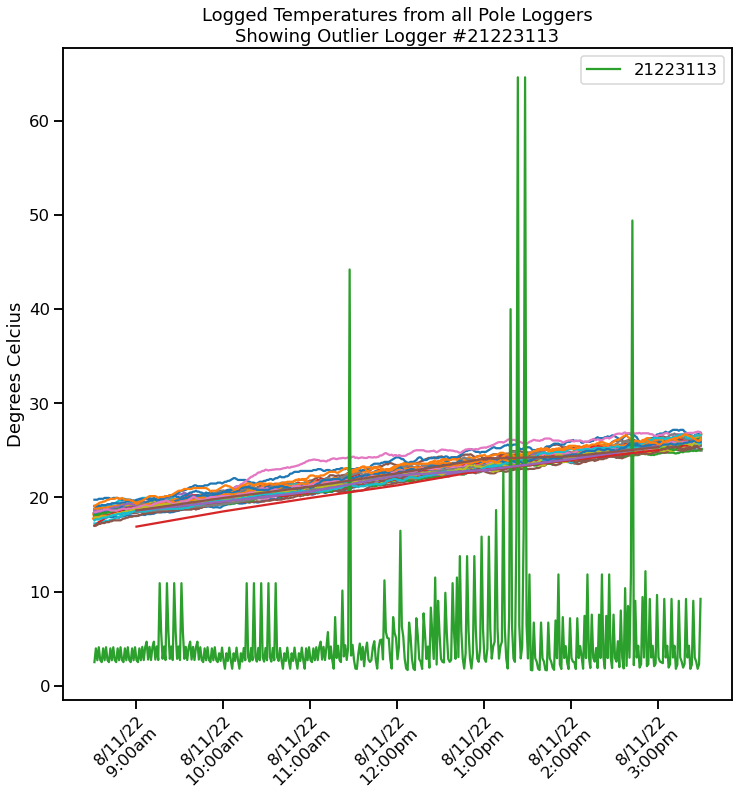

In [175]:
#Load pole logger temperature file to explore outlier in bottom right of previous figure
PoleLoggers = pd.read_csv('PoleLoggerValues.csv').iloc[:, 1:]
PoleLoggers.DateTime = pd.to_datetime(PoleLoggers.DateTime)
PoleLoggerNums = PoleLoggers['LoggerNum'].unique().tolist()
LoggerDict = {}
for Logger in PoleLoggerNums:
    LoggerDict[Logger] = PoleLoggers[PoleLoggers['LoggerNum'] == Logger]

#plot each pole logger as an individual line on the same axis and show outlier logger in legend
fig, ax = plt.subplots(sharex=True, sharey=True, figsize = (12,12))
for key, value in LoggerDict.items():
    if key == 21223113:
        ax.plot(value['DateTime'], value['Temp'], label = f'{key}')
    else: ax.plot(value['DateTime'], value['Temp'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
ax.set_ylabel('Degrees Celcius')
ax.set_title('Logged Temperatures from all Pole Loggers\nShowing Outlier Logger #21223113')
ax.set_xticklabels(['8/11/22\n9:00am','8/11/22\n10:00am','8/11/22\n11:00am','8/11/22\n12:00pm', '8/11/22\n1:00pm', '8/11/22\n2:00pm', '8/11/22\n3:00pm'])
plt.legend()
plt.show()

### Temperatures by Shift
With the logged values split into individual shifts, it shows how comparably variable the logged surface temperatures are compared to the pole temperatures. Surface values fluctuated wildly compared to the pole temperatures and and also saw a median increase throughout the day of over 10C compared to the pole temperature increase of about 7C. Much of this fluctuation is due to the lack of a diffuser surrounding the surface loggers like the pole loggers have. However, given that the surface loggers are only given 5 minutes for their temperatures to stabilize while the pole loggers were allowed to stay in place all day, there's potential for temperature discrepency due to lack of stabilization time.

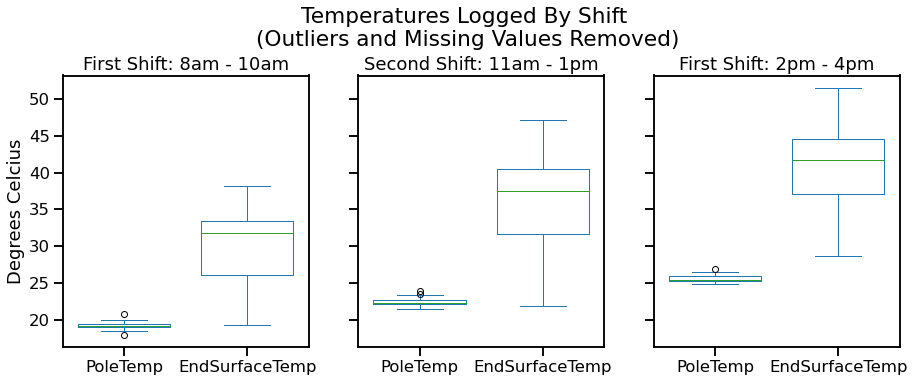

In [176]:
###Removed incorrect pole temp value logged near 3pm from outlier pole logger and removed missing data values from surface logger data
###Divided the temperature data into Blitz shifts
AugBlitzOutliersRemoved = AugBlitz[(AugBlitz['PoleTemp'] > 10) & (AugBlitz['EndSurfaceTemp'] > 10)]
Shift1 = AugBlitzOutliersRemoved[AugBlitzOutliersRemoved.DateTime < '8-11-2022 11:00:00']
Shift2 = AugBlitzOutliersRemoved[(AugBlitzOutliersRemoved.DateTime > '8-11-2022 11:00:00') & (AugBlitzOutliersRemoved.DateTime < '8-11-2022 14:00:00')]
Shift3 = AugBlitzOutliersRemoved[AugBlitzOutliersRemoved.DateTime > '8-11-2022 14:00:00']

sns.set_context('talk')
fig, (ax1, ax2, ax3) =  plt.subplots(1, 3, sharex=False, sharey = True, figsize=(15,5)) 
Shift1[['PoleTemp', 'EndSurfaceTemp']].plot(ax=ax1, kind='box', title = 'First Shift: 8am - 10am', widths=(0.75, 0.75))
Shift2[['PoleTemp', 'EndSurfaceTemp']].plot(ax=ax2, kind='box', title = 'Second Shift: 11am - 1pm', widths=(0.75, 0.75))
Shift3[['PoleTemp', 'EndSurfaceTemp']].plot(ax=ax3, kind='box', title = 'First Shift: 2pm - 4pm', widths=(0.75, 0.75))
ax1.set_ylabel('Degrees Celcius')
plt.suptitle('Temperatures Logged By Shift \n(Outliers and Missing Values Removed)', y=1.07)
plt.show()

### Displaying Surface Logger Temperatures Throughout the Blitz
Surface loggers displayed a significant amount more variance than the pole loggers throughout the day of the Blitz. This is due to two main factors: 1) The surface loggers were carried to different pole loggers resulting in testing in multiple locations 2) The surface loggers were lacking the outside diffusers fitted to pole loggers that help to wild temperature swings from direct sunlight.

The second aspect to notice with this chart is that while the surface loggers did manage to coalesce when brought together outside of "shift" times (<8:30am, 11am, 2pm, >4pm), there is a defined curve displayed primarily at 4pm (but also around 10am) showing that it takes some time for temperature readings to stabilize. This leads to a hypothesis that the 5 minutes of stabilization time given during the Blitz may not have been a long enough time for surface logger temperatures to properly stabilize.

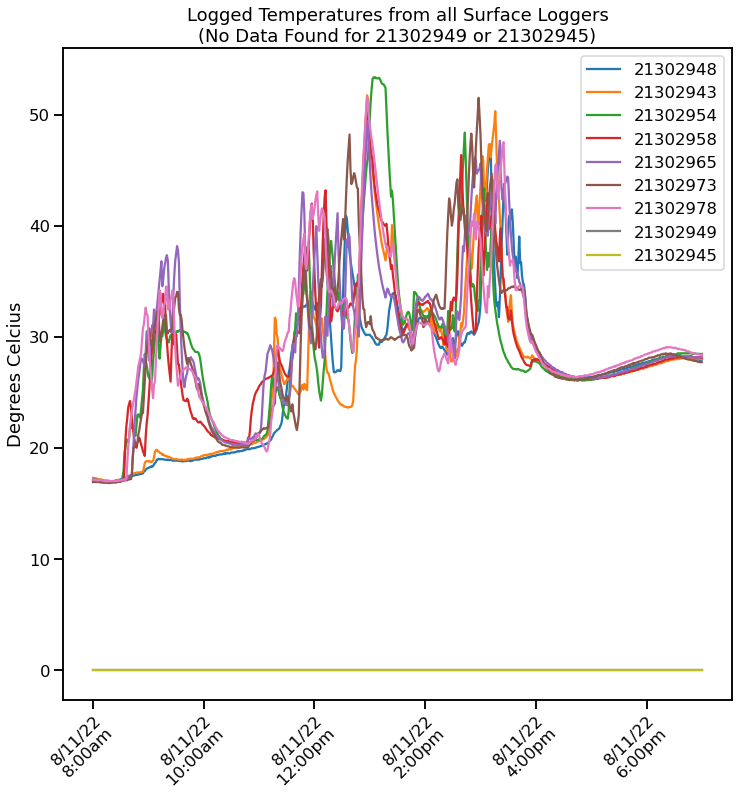

In [177]:
#plot all surface temperature loggers overlapping to show progresssion throughout the day
SurfaceLoggers = pd.read_csv('SurfaceLoggerValues.csv')
SurfaceLoggers['DateTime']= pd.to_datetime(SurfaceLoggers['Unnamed: 0'])
SurfaceLoggers = SurfaceLoggers.set_index('DateTime').iloc[:,1:10]
SurfaceLoggerList = list(SurfaceLoggers.columns)

fig, ax = plt.subplots(sharex=True, sharey=True, figsize = (12,12))
for Logger in SurfaceLoggerList:
    ax.plot(SurfaceLoggers.index, SurfaceLoggers[f'{Logger}'], label = f'{Logger}')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
ax.set_ylabel('Degrees Celcius')
ax.set_title('Logged Temperatures from all Surface Loggers\n(No Data Found for 21302949 or 21302945)')
ax.set_xticklabels(['8/11/22\n8:00am','8/11/22\n10:00am','8/11/22\n12:00pm','8/11/22\n2:00pm', '8/11/22\n4:00pm', '8/11/22\n6:00pm'])
plt.legend()
plt.show()


### Exploring the Efficacy of 5 Minute Intervals for Surface Logger Temperature Stabilization
Using the same data shown in two separate methods for clarity, it is shown more clearly that there appears to be very little temperature stabilization achieved in 5 minutes - indicating that the final temperatures recorded are likely not the true values for that location.

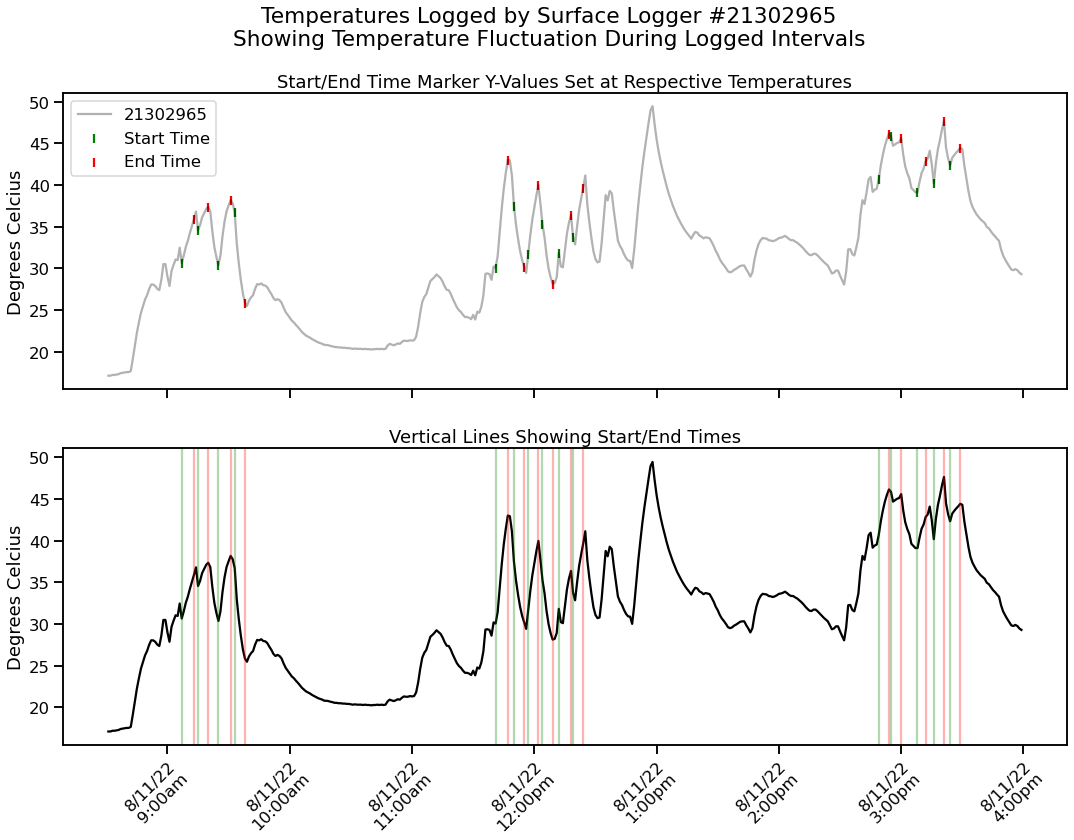

In [178]:
#experimenting with a single surface logger to see the effect that the 5 minutes had on temperature readings
Blitz21302965 = AugBlitz[AugBlitz['SurfaceLogger'] == 21302965]

#compile a list of start and end times recorded with logger 21302965
StartTimes = Blitz21302965['StartTime'].tolist()
EndTimes = Blitz21302965['EndTime'].tolist()
StartSurfaceTemp = Blitz21302965['StartSurfaceTemp'].tolist()
EndSurfaceTemp = Blitz21302965['EndSurfaceTemp'].tolist()

#shorten times to including only times during Blitz to better fit screen
SurfaceLoggersShortened = SurfaceLoggers[(SurfaceLoggers.index  < '2022-08-11 16:00:00') & (SurfaceLoggers.index  > '2022-08-11 8:30:00')]

#plotted first chart showing the temperature logged at the start/end midpoint as well as showing start/end times
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize = (18,12))
for Logger in SurfaceLoggerList:
    if Logger == '21302965':
        ax1.plot(SurfaceLoggersShortened.index, SurfaceLoggersShortened[f'{Logger}'], label = f'{Logger}', alpha = .3, color = 'black')
ax1.set_title('Start/End Time Marker Y-Values Set at Respective Temperatures')
ax1.scatter([StartTimes], [StartSurfaceTemp], marker = '|', color = 'green', label = 'Start Time')
ax1.scatter([EndTimes], [EndSurfaceTemp], marker = '|', color = 'red', label = 'End Time')
ax1.legend()

#created lines on x axis to better visualize the temperature at the start/end times
for Logger in SurfaceLoggerList:
    if Logger == '21302965':
        ax2.plot(SurfaceLoggersShortened.index, SurfaceLoggersShortened[f'{Logger}'], label = f'{Logger}', color = 'black')
ax2.set_title('Vertical Lines Showing Start/End Times')
ax2.set_xticklabels(['8/11/22\n9:00am','8/11/22\n10:00am','8/11/22\n11:00am','8/11/22\n12:00pm', '8/11/22\n1:00pm', '8/11/22\n2:00pm', '8/11/22\n3:00pm', '8/11/22\n4:00pm'])

axes = [ax1, ax2]
for ax in axes:
    ax.set_ylabel('Degrees Celcius')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)

for StartTime in StartTimes:
    ax2.axvline(x=StartTime, color = 'g', alpha = .3)
for EndTime in EndTimes:
    ax2.axvline(x=EndTime, color = 'r', alpha = .3)    
plt.suptitle('Temperatures Logged by Surface Logger #21302965\nShowing Temperature Fluctuation During Logged Intervals')
plt.show()

### Displaying the Temperature Readings for Each 5 Minute Interval for Logger 21302965
By displaying each logging interval separately, it is clear that in nearly every case temperature stabilization was not reached in the 5 minutes. It is, however, interesting to note that each of stabilization periods appear to follow a similar curve 

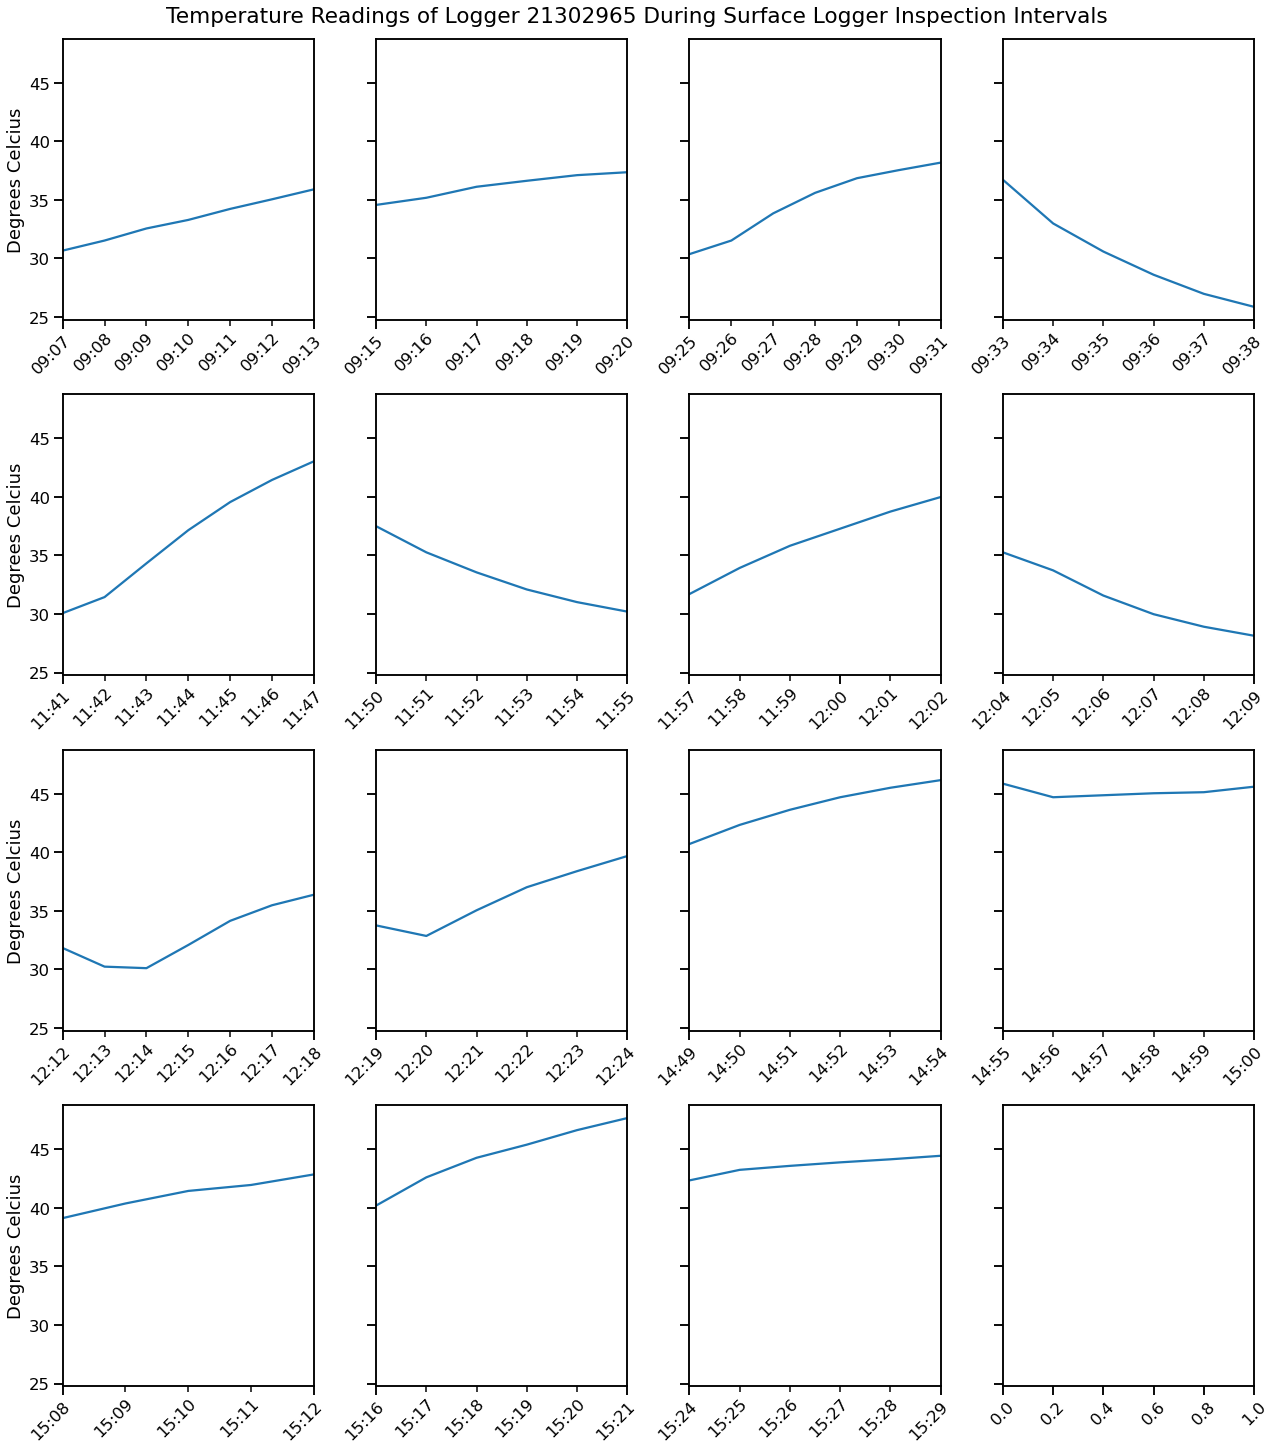

In [179]:
#plotted surface temperature changes of 21302965 during Blitz readings
TimeDict = {StartTimes[i]: EndTimes[i] for i in range(len(StartTimes))}
Logger21302965 = SurfaceLoggers['21302965']
Logger21302965 = pd.DataFrame({'DateTime':Logger21302965.index, 'Temp':Logger21302965.values})
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(18, 20), sharex=False, sharey = True)
for (Start, End), ax in zip(TimeDict.items(), axs.ravel()):
    Interval = Logger21302965[(Logger21302965.DateTime >= Start) & (Logger21302965.DateTime <= End)]
    Interval = Interval.set_index('DateTime', drop=True)
    Interval.plot(ax=ax)
    ax.get_legend().remove()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
    ax.set_xlabel("")
    ax.set_ylabel('Degrees Celcius')
    fig.tight_layout(pad=1.0)
plt.xticks(rotation = 45)
plt.suptitle('Temperature Readings of Logger 21302965 During Surface Logger Inspection Intervals', y=1.01)
plt.show()   

### Identifying an Undisturbed Temperature Curve to Extrapolate
Upon inspecting each temperature logger for a usable stabilization curve, logger #21302954 was found to exhibit a smooth stabilization curve from 3:12pm to 3:44pm. In this window, logged temperature decreased 12C. It is hypothesized that by matching the total temperature change in a 5 minute interval to the rate of change displayed in this window, we can more accurately assign temperature values to logged intervals than were actually recorded. 

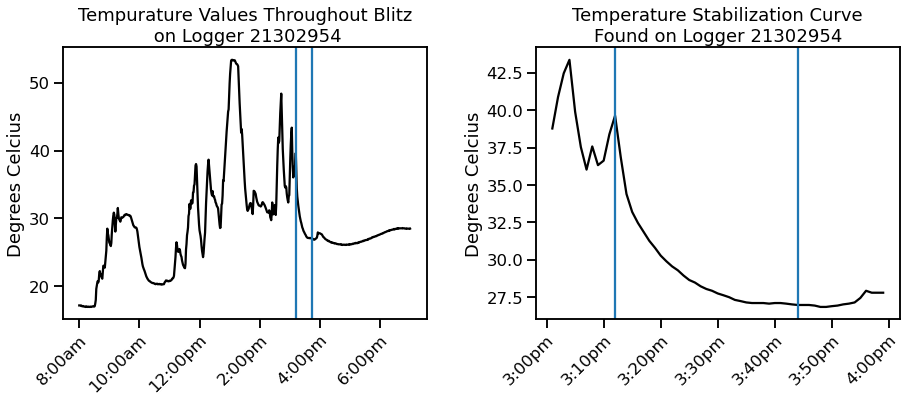

In [180]:
SurfaceLoggerCurve = SurfaceLoggers[(SurfaceLoggers.index  < '2022-08-11 16:00:00') & (SurfaceLoggers.index  > '2022-08-11 15:00:00')]
#plotted first chart showing the temperature logged at the start/end midpoint as well as showing start/end times
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey= False, figsize=(15,5))
fig.subplots_adjust(wspace=.3)
for Logger in SurfaceLoggerList:
    if Logger == '21302954':
        ax2.plot(SurfaceLoggerCurve.index, SurfaceLoggerCurve[f'{Logger}'], label = f'{Logger}', color = 'black')
for Logger in SurfaceLoggerList:
    if Logger == '21302954':
        ax1.plot(SurfaceLoggers.index, SurfaceLoggers[f'{Logger}'], label = f'{Logger}', color = 'black')

axes = [ax1, ax2]
for ax in axes:
    ax.axvline(dt.datetime(2022, 8, 11, 15, 12))
    ax.axvline(dt.datetime(2022, 8, 11, 15, 44))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
    ax.set_ylabel('Degrees Celcius')
ax1.set_title('Tempurature Values Throughout Blitz\n on Logger 21302954')
ax2.set_title('Temperature Stabilization Curve\nFound on Logger 21302954')
ax1.set_xticklabels(['8:00am', '10:00am', '12:00pm', '2:00pm', '4:00pm', '6:00pm'])
ax2.set_xticklabels(['3:00pm', '3:10pm', '3:20pm', '3:30pm', '3:40pm', '3:50pm', '4:00pm'])
plt.show()

### Forming Temperature Change Rates to Extrapolate
This hypothesis is based on the assumption that the more the temperature changes over the 5 minute logging interval, the further the inital logged temperature is from the actual temperature. In this instance, as the logger recorded a stable temperature of 27C for around 10 minutes, 27C is assumed to be the true temperature that was being approached since 3:12pm. 

Using this assumption, we see that even though the first 5 minutes saw a 7.77C change from the initial temperature of 39.5C, it should have decreased 12.64C to the expected true temperature of 27C. Similarly, from the 2nd minute to the 7th minute, there was a recorded drop of 3.6C but the expected true temperature was 7.4C lower. 

Using these actual vs expected changes, it's possible to take the recorded data and merge the actual recorded temperature changes throughout the Blitz to calculate an expected final temperature by using this curve.

In [181]:
Logger2954 = SurfaceLoggers['21302954'] #identified logger with clean temperature curve during Blitz
Logger2954Curve = Logger2954[(Logger2954.index > '2022-08-11 15:11:00') & (Logger2954.index < '2022-08-11 15:45:00')].reset_index()  #Select curve times only

#may be worth adding row with a higher temperature change. Largest sampled change was 8C. Several data values in Augblitz exceeded 12C

####new_row = pd.DataFrame({'DateTime':'2022-08-11 15:11:00', '21302954':43}, index =[0]) #created new row value for extreme temperature changes
####Logger2954Curve = pd.concat([new_row, Logger2954Curve]).reset_index(drop = True) #added row to DF

Logger2954Curve['TempDiff'] = Logger2954Curve['21302954'].diff() #identify minute by minute change
Logger2954Curve['Total5MinTempChange'] = Logger2954Curve['TempDiff'].rolling(min_periods=5, window=5).sum() #sum up each set of 5 minute temperaute change intervals
Logger2954Curve['ExpectedTotalChange'] = Logger2954Curve['Total5MinTempChange'] - (Logger2954Curve['21302954'] - 27) #find difference between end of 5 minute change and full temperature stabilization (27C)
Logger2954Curve = Logger2954Curve.iloc[5:30, [3,4]]#ignore NaN rows and rows with no change
Logger2954CurvePos = abs(Logger2954Curve).iloc[::-1]  #create matching DF of temperature increase and flip row order
Logger2954Curve = pd.concat([Logger2954Curve, Logger2954CurvePos]).reset_index(drop=True) #concat DFs together for one DF that can be merged to
Logger2954Curve

,Total5MinTempChange,ExpectedTotalChange
0,-7.77,-12.64
1,-5.58,-9.85
2,-3.60,-7.40
3,-2.92,-6.20
4,-2.57,-5.47
5,-2.31,-4.87
6,-1.97,-4.27
7,-1.85,-3.80
8,-1.63,-3.28
9,-1.42,-2.90


### An Expected Surface Temp Column is Calculated and Added to the AugBlitz Database
In adding the Expected Surface Temp to the AugBlitz DataFrame, we are presented with values that appear to match quite well what should be expected. In the first row we started at 24C and ended at 20C. As we've seen, 5 minutes is not enough time for the loggers to reach the correct value, so the value should be lower than 20C. With this calculation, we are given an Expected Surface temp of 16.84C which matches the rate of change exhibited in the extrapolated curve.  

In [182]:
AugBlitzOutliersRemoved['Total5MinTempChange'] = AugBlitzOutliersRemoved['EndSurfaceTemp'] - AugBlitzOutliersRemoved['StartSurfaceTemp'] #calculate observed difference between start and end times
AugBlitzOutliersRemoved = AugBlitzOutliersRemoved.sort_values('Total5MinTempChange').reset_index(drop=True) #sort by total observed temperature change to perform merge_asof
Logger2954Curve.Total5MinTempChange = np.round(Logger2954Curve.Total5MinTempChange*100).astype(int) #change floats to integers by multiply by 100
AugBlitzOutliersRemoved.Total5MinTempChange = np.round(AugBlitzOutliersRemoved.Total5MinTempChange*100).astype(int) #same of merge column
AugBlitzOutliersRemoved = pd.merge_asof(AugBlitzOutliersRemoved, Logger2954Curve, left_on='Total5MinTempChange', right_on='Total5MinTempChange', direction='nearest') #merge dataset of expected values to nearest match of Blitz
AugBlitzOutliersRemoved = AugBlitzOutliersRemoved.sort_values(by='DateTime').reset_index(drop=True) #re-sort data by time
AugBlitzOutliersRemoved['ExpectedSurfaceTemp'] = AugBlitzOutliersRemoved['StartSurfaceTemp'] + AugBlitzOutliersRemoved['ExpectedTotalChange'] #calculate expected temperature by adding to start time
AugBlitzOutliersRemoved['Total5MinTempChange'] = AugBlitzOutliersRemoved['Total5MinTempChange']/100 # divide previously multipled values by 100 to reflect actual changes
AugBlitzOutliersRemoved

,DateTime,StartTime,EndTime,SurfaceLogger,StartSurfaceTemp,EndSurfaceTemp,PoleLogger,PoleTemp,Utility Pole #,Latitude,...,Trees?,SummedBA,DistanceDecay,Sun/Shade Binary,Tree Binary,Minute of Day,Hour of Day,Total5MinTempChange,ExpectedTotalChange,ExpectedSurfaceTemp
0,2022-08-11 08:46:00,2022-08-11 08:40:00,2022-08-11 08:46:00,21302958,24.24,20.16,21302967,17.930,TP6262,47.213277,...,Y,2.424760,0.041437,0,1,526.0,8,-4.08,-7.40,16.84
1,2022-08-11 08:56:00,2022-08-11 08:50:00,2022-08-11 08:56:00,21302958,20.93,19.30,21223106,18.711,TPU927,47.214566,...,N,0.000000,0.000000,0,0,536.0,8,-1.63,-3.28,17.65
2,2022-08-11 08:56:00,2022-08-11 08:51:00,2022-08-11 08:56:00,21302954,22.73,28.48,21302950,18.530,TP6340,47.216117,...,N,0.000000,0.000000,1,0,536.0,8,5.75,9.85,32.58
3,2022-08-11 08:57:00,2022-08-11 08:52:00,2022-08-11 08:57:00,21302978,28.53,32.64,21223121,19.282,TP23269,47.216736,...,N,0.018928,0.000386,1,0,537.0,8,4.11,7.40,35.93
4,2022-08-11 09:00:00,2022-08-11 08:55:00,2022-08-11 09:00:00,21302973,24.66,30.07,21223123,19.187,TP20171,47.209033,...,N,0.000000,0.000000,1,0,540.0,9,5.41,9.85,34.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2022-08-11 15:22:00,2022-08-11 15:16:00,2022-08-11 15:22:00,21302973,38.39,34.02,21223135,25.319,TP20080,47.199322,...,Y,0.695293,0.018844,0,1,922.0,15,-4.37,-7.40,30.99
83,2022-08-11 15:23:00,2022-08-11 15:19:00,2022-08-11 15:23:00,21302978,42.47,46.29,21302971,26.340,TP25239/A1353202,47.226325,...,N,0.000000,0.000000,1,0,923.0,15,3.82,7.40,49.87
84,2022-08-11 15:25:00,2022-08-11 15:20:00,2022-08-11 15:25:00,21302954,30.28,28.65,21302963,25.350,TP6325,NaN,...,NaN,0.000000,0.000000,1,0,925.0,15,-1.63,-3.28,27.00
85,2022-08-11 15:29:00,2022-08-11 15:24:00,2022-08-11 15:29:00,21302965,42.34,44.44,21223102,25.319,TP13987,47.220944,...,Y,0.141372,0.006381,1,1,929.0,15,2.10,4.27,46.61


### Visualizing Data with a Heatmap of Correlation Values
There are several values here that are interesting - most of them having to do with the Expected Surface Temperature calculations that were recently performed. As expected, the Expected Temperatures correlates higher to the Sun/Shade Binary than the End Surface Temperature. Given that the surface loggers did not have a diffuser, Sun/Shade Binary is a much greater driver of values for the surface logger than minute of the day. This could be the reason for the the Expected Surface Temperature's lower correlation to Minute of Day values than End Surface Temperature - because End Temp is unable to fully stabilize upward or downward, it likely remains closer to a median point leading to a closer correlation with Minute of Day.

It is also interesting to note that the Distance Decay formula (which factors in tree distance from logger in Summed Basal Area calculations) more negatively correlates to each temperature value than Summed Basal Area by itself. 

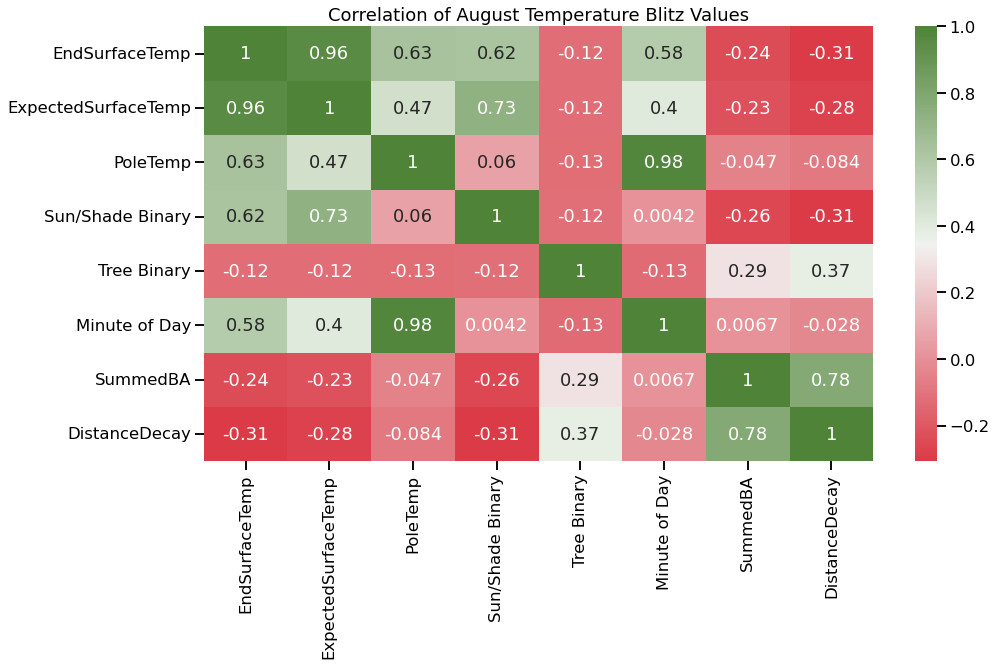

In [183]:
#create heatmap correlation of known values.
sns.set_context('talk')
corr = AugBlitzOutliersRemoved[['EndSurfaceTemp', 'ExpectedSurfaceTemp', 'PoleTemp', 'Sun/Shade Binary', 'Tree Binary', 'Minute of Day', 'SummedBA', 'DistanceDecay']].corr()
plt.figure(figsize = (15,8))
sns.heatmap(corr, cmap=sns.diverging_palette(10, 120, as_cmap=True), annot=True)
plt.title('Correlation of August Temperature Blitz Values')
plt.show()

### Linear Regression Coefficients and Statistical Significance of Variables of Surface and Pole Temperatures
Here variables are calculated and shown by their regression coefficient (green) and P-value (blue). 

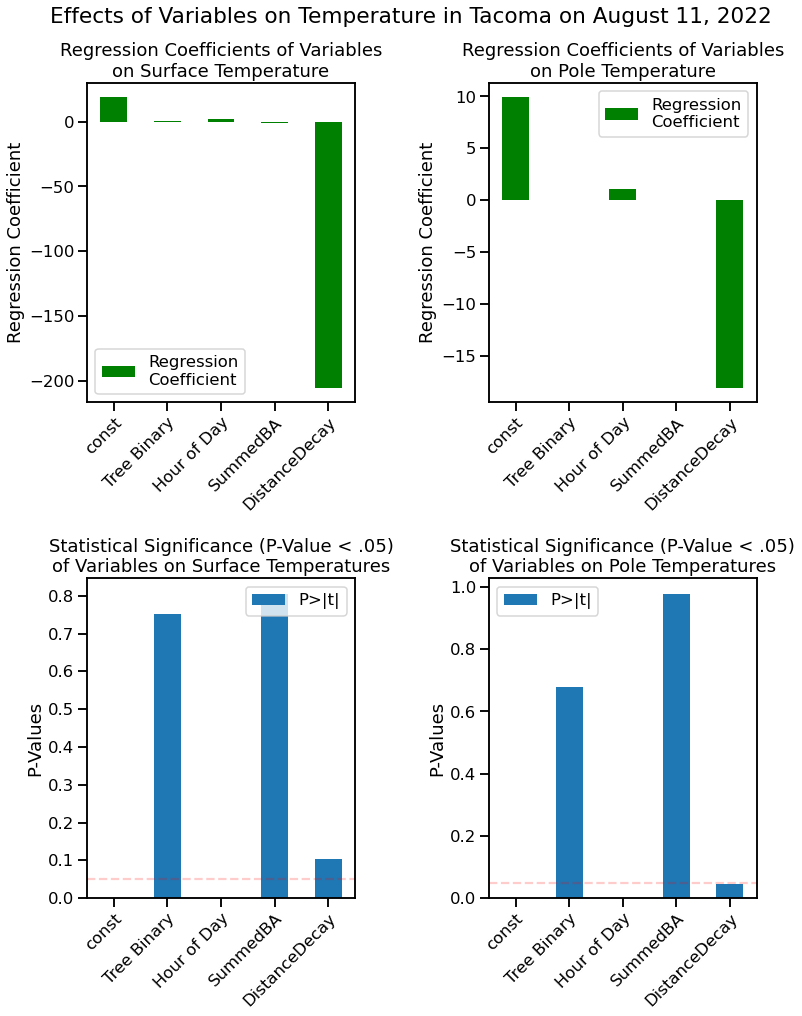

In [188]:
reg_variables = ['Tree Binary', 'Hour of Day', 'SummedBA', 'DistanceDecay']

dep_var1 = AugBlitzOutliersRemoved[['ExpectedSurfaceTemp']]
indep_vars1 = AugBlitzOutliersRemoved[reg_variables]
indep_vars_c1 = sm.add_constant(indep_vars1)
regression_model_surface= sm.OLS(dep_var1, indep_vars_c1).fit()
Surface_values = regression_model_surface.summary2().tables[1]['P>|t|']
Surface_valuesdf = pd.DataFrame(Surface_values)

NoPoleNaN = AugBlitzOutliersRemoved.dropna(subset=['PoleTemp'])
dep_var2 = NoPoleNaN[['PoleTemp']]
indep_vars2 = NoPoleNaN[reg_variables]
indep_vars_c2 = sm.add_constant(indep_vars2)
regression_model_pole = sm.OLS(dep_var2, indep_vars_c2).fit()
Pole_values = regression_model_pole.summary2().tables[1]['P>|t|']
Pole_valuesdf = pd.DataFrame(Pole_values)

#plot both the regression coefficient and the P-value
fig, ((ax2,ax3),(ax4,ax5)) = plt.subplots(2, 2, sharex=False, sharey= False, figsize=(12,15)) 
plt.subplots_adjust(wspace=.5, hspace=.55)

regression_model_surface.params.plot(ax=ax2, kind='bar', color='green', label='Regression\nCoefficient', title = 'Regression Coefficients of Variables\non Surface Temperature')

regression_model_pole.params.plot(ax=ax3, kind='bar', color='green', label='Regression\nCoefficient', title = 'Regression Coefficients of Variables\non Pole Temperature')

Surface_valuesdf.plot(ax=ax4, kind='bar', title = 'Statistical Significance (P-Value < .05)\nof Variables on Surface Temperatures')

Pole_valuesdf.plot(ax=ax5, kind='bar', title = 'Statistical Significance (P-Value < .05)\nof Variables on Pole Temperatures')

axes = [ax2, ax3, ax4, ax5]
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    if ax in (ax2, ax3): ax.set_ylabel('Regression Coefficient')
    else: ax.set_ylabel('P-Values')
    ax.legend()
    if ax in (ax4, ax5): ax.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
plt.suptitle('Effects of Variables on Temperature in Tacoma on August 11, 2022', y=.95)
plt.show()

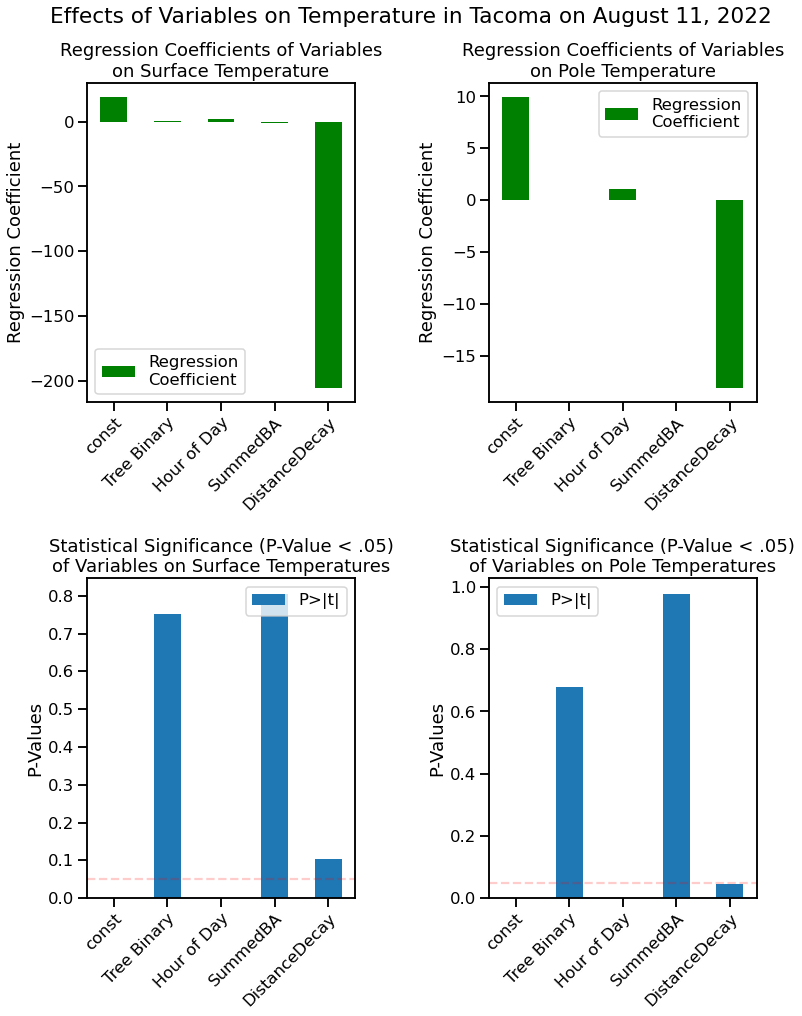

In [187]:
reg_variables = ['Tree Binary', 'Hour of Day', 'SummedBA', 'DistanceDecay']

Sunny_AugBlitzOutliersRemoved = AugBlitzOutliersRemoved
Sunny_AugBlitzOutliersRemoved
dep_var1 = Sunny_AugBlitzOutliersRemoved[['ExpectedSurfaceTemp']]
indep_vars1 = Sunny_AugBlitzOutliersRemoved[reg_variables]
indep_vars_c1 = sm.add_constant(indep_vars1)
regression_model_surface= sm.OLS(dep_var1, indep_vars_c1).fit()
Surface_values = regression_model_surface.summary2().tables[1]['P>|t|']
Surface_valuesdf = pd.DataFrame(Surface_values)

NoPoleNaN = Sunny_AugBlitzOutliersRemoved.dropna(subset=['PoleTemp'])
dep_var2 = NoPoleNaN[['PoleTemp']]
indep_vars2 = NoPoleNaN[reg_variables]
indep_vars_c2 = sm.add_constant(indep_vars2)
regression_model_pole = sm.OLS(dep_var2, indep_vars_c2).fit()
Pole_values = regression_model_pole.summary2().tables[1]['P>|t|']
Pole_valuesdf = pd.DataFrame(Pole_values)

#plot both the regression coefficient and the P-value
fig, ((ax2,ax3),(ax4,ax5)) = plt.subplots(2, 2, sharex=False, sharey= False, figsize=(12,15)) 
plt.subplots_adjust(wspace=.5, hspace=.55)

regression_model_surface.params.plot(ax=ax2, kind='bar', color='green', label='Regression\nCoefficient', title = 'Regression Coefficients of Variables\non Surface Temperature')

regression_model_pole.params.plot(ax=ax3, kind='bar', color='green', label='Regression\nCoefficient', title = 'Regression Coefficients of Variables\non Pole Temperature')

Surface_valuesdf.plot(ax=ax4, kind='bar', title = 'Statistical Significance (P-Value < .05)\nof Variables on Surface Temperatures')

Pole_valuesdf.plot(ax=ax5, kind='bar', title = 'Statistical Significance (P-Value < .05)\nof Variables on Pole Temperatures')

axes = [ax2, ax3, ax4, ax5]
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    if ax in (ax2, ax3): ax.set_ylabel('Regression Coefficient')
    else: ax.set_ylabel('P-Values')
    ax.legend()
    if ax in (ax4, ax5): ax.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
plt.suptitle('Effects of Variables on Temperature in Tacoma on August 11, 2022', y=.95)
plt.show()